In [ ]:
from detector_dataset import DetectorDataset

In [ ]:
root = "data\\plane_data"

In [ ]:
detector = DetectorDataset(root, None)

In [ ]:
from torchvision.transforms import v2 as T
import torch

def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
from detector_module import CocoDetectorModule, CocoDetectorResnet
from custom_dataset import PennFudanDataset
from torch.utils.data import Subset, DataLoader

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


module = CocoDetectorModule(CocoDetectorResnet(2, 0.1))

BATCH_SIZE = 2

dataset = DetectorDataset(root, get_transform(False))

loader_train = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)

In [ ]:
import lightning as L

trainer = L.Trainer(limit_train_batches=100, max_epochs=1, accelerator="gpu")
trainer.fit(model=module, train_dataloaders=loader_train)
trainer.test(model=module, dataloaders=loader_train)

In [ ]:
from torchvision.utils import draw_bounding_boxes
from torchvision.io import read_image
import matplotlib.pyplot as plt

image = read_image("data/plane_data/images/sample.jpg")
eval_transform = get_transform(train=False)

x = eval_transform(image)
# convert RGBA -> RGB and move to device
x = x[:3, ...].to("cpu")
print(x.shape)
pred = module.predict([x,])[0]


image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"{['plane', 'car'][label]}: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
print(pred["labels"])
pred_boxes = pred["boxes"].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")


plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))

In [ ]:
image = read_image("data/plane_data/images/sample.jpg")
eval_transform = get_transform(train=False)

x = eval_transform(image)
# convert RGBA -> RGB and move to device
x = x[:3, ...].to("cpu")

pred_data = [x, x]
pred = module.predict(pred_data)

In [ ]:
from pathlib import Path
import os

document_root = Path(os.getenv('LOCAL_FILES_DOCUMENT_ROOT', default='/'))
relative_path = str(os.path.relpath(document_root))

In [ ]:
os.path.abspath(os.curdir)

In [ ]:
from data_utils import serialize_predictions
import os

image_shapes = [x.shape for x in pred_data]


image_paths = ["e_motion/ml/data/plane_data/images/sample.jpg"] * len(image_shapes)  # TODO
classes = ["Airplane", "Car"] # TODO

serialized = serialize_predictions(image_shapes, pred, image_paths, "model1", classes)

In [ ]:
serialized

In [ ]:
import json
with open("test.json", "w") as f:
    f.write(json.dumps(serialized))

In [ ]:
from torchvision.utils import draw_bounding_boxes
import matplotlib.pyplot as plt


data = dataset[1]

image = data[0]
pred = data[1]


image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"{['plane', 'car'][label]}" for label in pred["labels"]]
pred_boxes = pred["boxes"].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")


plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))

In [ ]:
from pycocotools.cocoeval import COCOeval
from pycocotools.coco import COCO

def load_coco_from_json(path):
    coco = COCO()
    with open(path) as json_file:
        json_data = json.load(json_file)
        coco.dataset = json_data
        coco.createIndex()
    return coco

def load_coco_from_prediction(prediction):
    coco = COCO()
    coco.dataset = prediction
    coco.createIndex()
    return coco

In [ ]:
from pycocotools.cocoeval import COCOeval
from pycocotools.coco import COCO

coco_gt = load_coco_from_json("data/plane_data/result.json")

image = read_image("data/plane_data/images/sample.jpg")
eval_transform = get_transform(train=False)

x = eval_transform(image)
# convert RGBA -> RGB and move to device
x = x[:3, ...].to("cpu")

pred_data = [x, x]
pred = module.predict(pred_data)

coco_pred = load_coco_from_prediction(pred)
# initialize the COCOeval object by passing the coco object with
# ground truth annotations, coco object with detection results
cocoEval = COCOeval(coco_gt, coco_pred, "bbox")

# run evaluation for each image, accumulates per image results
# display the summary metrics of the evaluation
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

In [ ]:
coco_pred.cats

In [1]:
from model_endpoint import load_images_for_prediction

In [1]:
from model_endpoint import train, predict

In [1]:
train("plane_data", "abc")

NameError: name 'train' is not defined

In [1]:
from model_endpoint import train, predict
predict("plane_data", "abc")[0]

{'data': {'image': 'images\\sample_test.jpg'},
 'predictions': [{'model_version': 'abc',
   'result': [{'original_width': 600,
     'original_height': 403,
     'image_rotation': 0,
     'from_name': 'label',
     'to_name': 'image',
     'type': 'rectanglelabels',
     'id': '0',
     'value': {'x': 19.766990661621094,
      'y': 0.05796695169680763,
      'width': 3.0121688842773438,
      'height': 1.3464365644431293,
      'rotation': 0,
      'rectanglelabels': ['Car']}},
    {'original_width': 600,
     'original_height': 403,
     'image_rotation': 0,
     'from_name': 'label',
     'to_name': 'image',
     'type': 'rectanglelabels',
     'id': '1',
     'value': {'x': 67.24923197428384,
      'y': 80.13785766904466,
      'width': 1.141626993815104,
      'height': 2.448259453028071,
      'rotation': 0,
      'rectanglelabels': ['Car']}},
    {'original_width': 600,
     'original_height': 403,
     'image_rotation': 0,
     'from_name': 'label',
     'to_name': 'image',
     

In [15]:
from torchvision.io import read_image
import torch
from torchvision.utils import draw_bounding_boxes
import matplotlib.pyplot as plt

image = read_image("data/plane_data/images/sample_test.jpg")

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


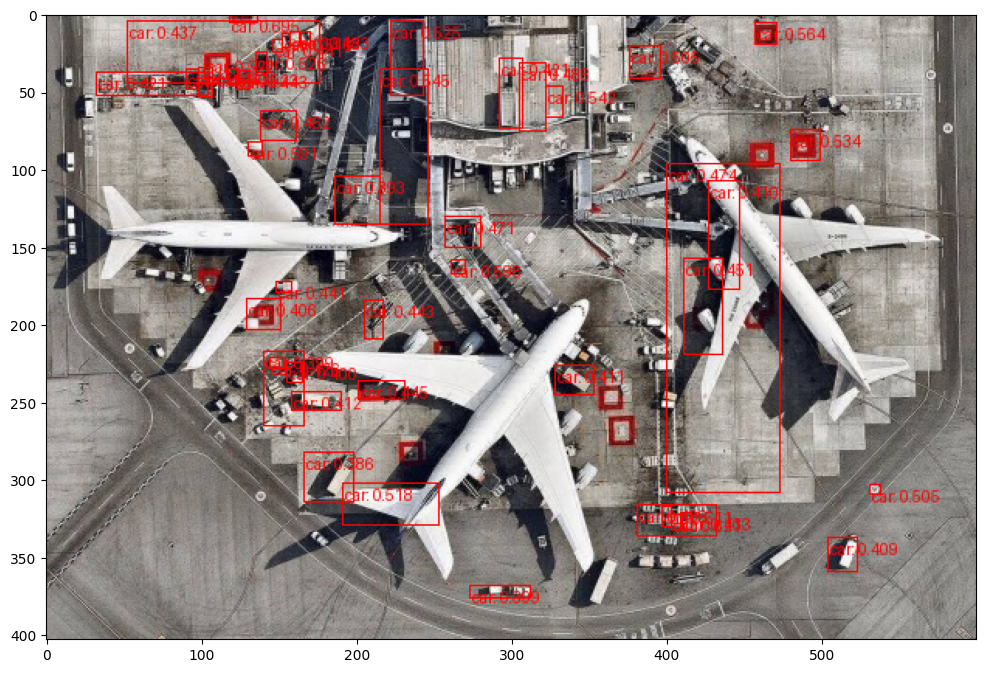

In [16]:
image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"{['plane', 'car'][label]}: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
print(pred["labels"])
pred_boxes = pred["boxes"].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")


plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))